In [15]:
import os
import pickle
from tqdm import tqdm
from itertools import chain

import numpy as np
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt

from dataset import get_dataset
from model import Model as Base
from utils.parse_logs import parse_configs, parse_metrics

In [2]:
EXP_DIR = 'results/smoothing/2024-06-27-16-41-29'
CKPT = 300
SPLIT = 'val'

with open(f'{EXP_DIR}/config.pkl', 'rb') as f:
    config = pickle.load(f)

DEVICE = torch.device(f'cuda:{config.device_index}' if torch.cuda.is_available() and config.device_index is not None else 'cpu')
dataset = get_dataset(config.dataset, config.task, DEVICE)
state_dict = torch.load(f'{EXP_DIR}/ckpt-{CKPT}.pt')

In [9]:
class Model(Base):

    def forward(self, x, edge_index, mask):

        for mp_layer in self.message_passing:
            x = mp_layer(x, edge_index)
            yield x

        out = self.readout(x, mask)
        yield out

model = Model(config).to(device=DEVICE)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
model.eval()

with torch.no_grad():
    *representations, logits = model(dataset.x, dataset.edge_index, mask=dataset.test_mask)

dataset.compute_loss(logits, dataset.y[dataset.test_mask])
dataset.compute_metrics()

[('Cross Entropy Loss', 0.5278717041015625),
 ('Accuracy', 0.8379963040351868),
 ('F1 Score', 0.8460693359375),
 ('AU-ROC', 0.9691168665885925)]

In [11]:
class Model(Base):

    def forward(self, x, edge_index, mask):

        for mp_layer in self.message_passing[:self.stop]:
            x = mp_layer(x, edge_index)

        out = self.readout(x, mask)
        return out

model = Model(config).to(device=DEVICE)
model.load_state_dict(state_dict)
model.stop = len(model.message_passing)

In [12]:
N_EPOCHS = [300]*4 + [150]*4
results = list()

for mp_steps in range(1, len(representations)+1):

    model.stop = mp_steps
    for ffn_layer in model.readout.ffn.children():
        ffn_layer.reset_parameters()
    optimizer = Adam(model.readout.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    results.append({'Val Metrics': list(), 'Test Metrics': list()})
    dataset.reset_metrics()
    for epoch in tqdm(range(N_EPOCHS[mp_steps-1])):
        train_metrics = dataset.train(model, optimizer)
        val_metrics, test_metrics = dataset.eval(model)
        results[-1]['Val Metrics'].append(val_metrics)
        results[-1]['Test Metrics'].append(test_metrics)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:17<00:00,  8.58it/s]


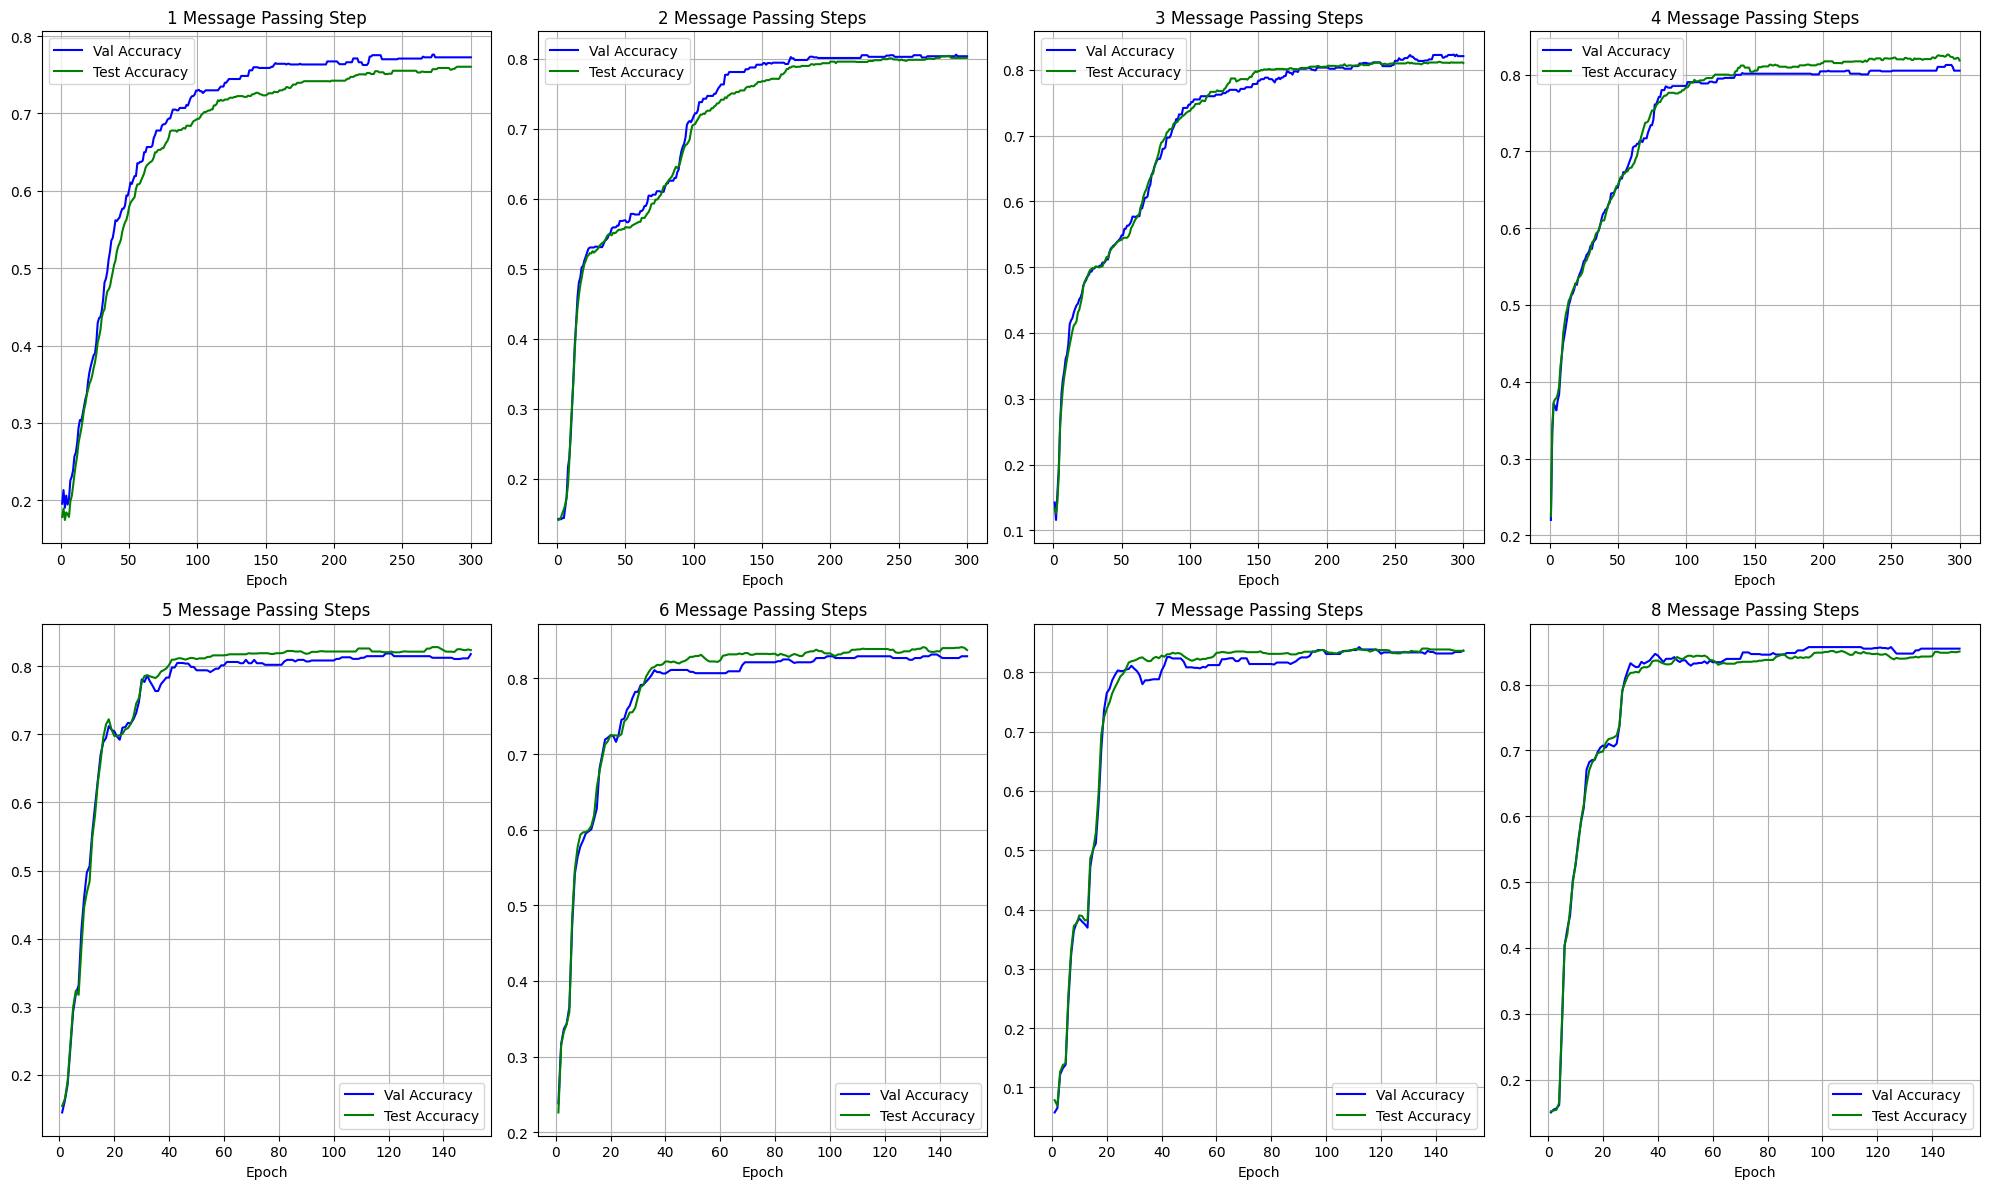

In [13]:
metric = 'Accuracy'
fig, axs = plt.subplots(2, 4, figsize=(20, 12))

for i in range(8):
    result = results[i]
    ax = axs[i//4, i%4]
    for (split, metrics), color in zip(result.items(), ('blue', 'green')):
        y = [val for x in metrics for name, val in x if name == metric]
        ax.plot(range(1, len(y)+1), y, color=color, label=split.replace('Metrics', metric))
    ax.set_xlabel('Epoch')
    ax.set_title(f'{i+1} Message Passing Step' + ('s' if i != 0 else ''))
    ax.grid()
    ax.legend()

fig.tight_layout()
plt.show()

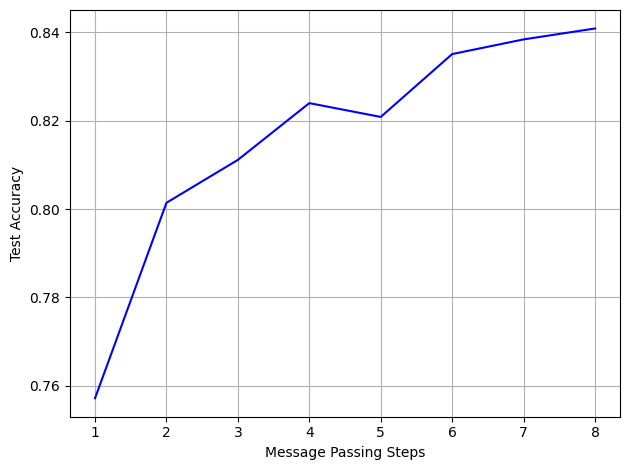

In [14]:
metric = 'Accuracy'
es_test_metrics = list()

for i in range(8):
    result = results[i]
    val_metrics = [dict(metrics)[metric] for metrics in result['Val Metrics']]
    best_epoch = np.argmax(val_metrics)
    test_metrics = [dict(metrics)[metric] for metrics in result['Test Metrics']]
    es_test_metrics.append(test_metrics[best_epoch])

plt.plot(range(1, 9), es_test_metrics, color='blue')
plt.xlabel('Message Passing Steps')
plt.ylabel(f'Test {metric}')
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
N_SAMPLES = 10
metric = 'Accuracy'
es_test_metrics = list()

for mp_steps in range(1, len(representations)+1):

    model.stop = mp_steps
    es_test_metrics.append(list())

    for sample in tqdm(range(N_SAMPLES)):

        for ffn_layer in model.readout.ffn.children():
            ffn_layer.reset_parameters()
        optimizer = Adam(model.readout.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        best_val_metric, es_test_metric = 0., 0.
        dataset.reset_metrics()
        for epoch in range(N_EPOCHS[mp_steps-1]):
            train_metrics = dataset.train(model, optimizer)
            val_metrics, test_metrics = dataset.eval(model)
            if dict(val_metrics)[metric] > best_val_metric:
                es_test_metric = dict(test_metrics)[metric]
        
        es_test_metrics[-1].append(es_test_metric)

100%|██████████| 10/10 [04:23<00:00, 26.31s/it]


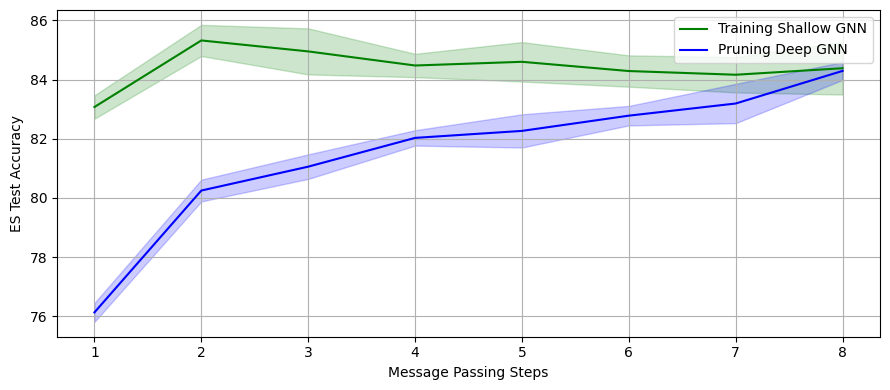

In [13]:
plt.figure(figsize=(9,4))

PAR_DIR = 'results/smoothing'
results = [list() for _ in range(len(es_test_metrics))]
for exp_dir in os.listdir(PAR_DIR)[1:161]:
    logs_fn = f'{PAR_DIR}/{exp_dir}/logs'
    config, (train_metrics, val_metrics, test_metrics) = parse_configs(logs_fn), parse_metrics(logs_fn)
    if config['gnn'] != 'GCN':
        continue
    depth = len(eval(config['gnn_layer_sizes']))
    best_epoch = np.argmax(val_metrics[metric])
    es_test_metric = 100*test_metrics[metric][best_epoch]
    results[depth-1].append(es_test_metric)

results = np.array(results)
means, std = np.mean(results, axis=1), np.std(results, axis=1)
lower, upper = means-std, means+std
    
plt.plot(range(1, len(means)+1), means, color='green', label='Training Shallow GNN')
plt.fill_between(range(1, len(means)+1), lower, upper, alpha=0.2, color='green')

lower, means, upper = list(), list(), list()
for result in es_test_metrics:
    mean, std = map(lambda x: 100*x, (np.mean(result), np.std(result)))
    lower.append(mean-std)
    means.append(mean)
    upper.append(mean+std)

plt.plot(range(1, len(means)+1), means, color='blue', label='Pruning Deep GNN')
plt.fill_between(range(1, len(means)+1), lower, upper, alpha=0.2, color='blue')

plt.xlabel('Message Passing Steps')
plt.ylabel(f'ES Test {metric}')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
N_EPOCHS = 2_500
xticks, lower, means, upper = list(), list(), list(), list()
losses = list()

for i, (x, y) in enumerate(zip(representations[:-1], representations[1:]), 1):
    xticks.append(f'{i}~{i+1}')
    linear_model = torch.nn.Linear(x.size(1), y.size(1))
    optimizer = Adam(linear_model.parameters(), lr=1.5e-2)
    losses.append(list())
    for _ in tqdm(range(N_EPOCHS)):
        optimizer.zero_grad()
        loss = torch.mean(torch.sum(torch.square(y-linear_model(x)), dim=1))
        losses[-1].append(loss.detach().item())
        loss.backward()
        optimizer.step()
    std_deviation, avg_deviation = map(lambda x: x.detach().item(), torch.std_mean(torch.norm(y-linear_model(x), p=2, dim=1)))
    lower.append(avg_deviation-std_deviation)
    means.append(avg_deviation)
    upper.append(avg_deviation+std_deviation)

100%|██████████| 2500/2500 [00:07<00:00, 344.59it/s]


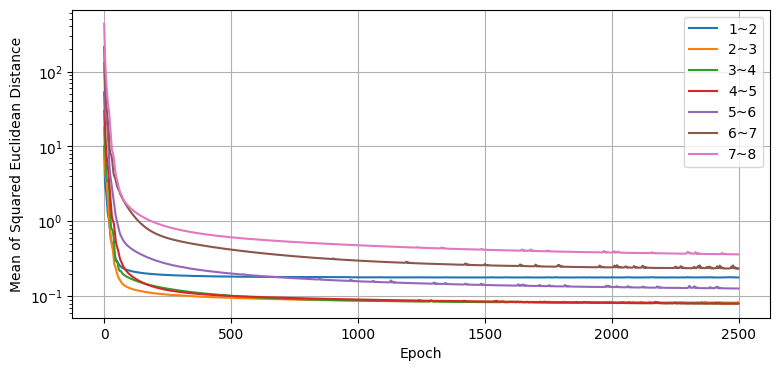

In [15]:
plt.figure(figsize=(9,4))

for xtick, loss in zip(xticks, losses):
    plt.plot(loss, label=xtick)

plt.xlabel('Epoch')
plt.ylabel('Mean of Squared Euclidean Distance')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

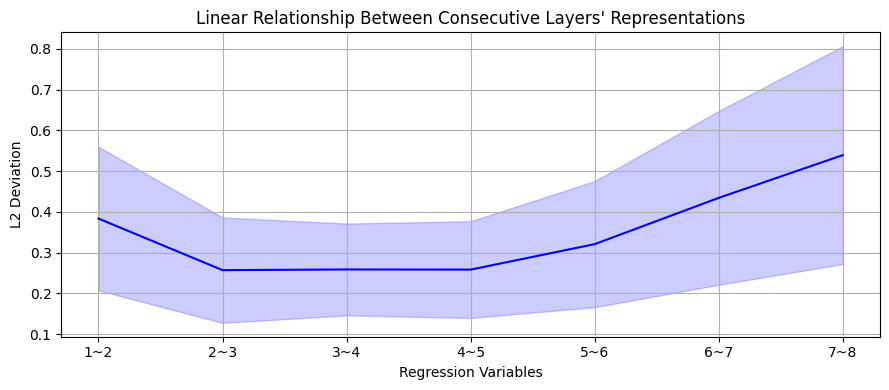

In [16]:
xticks = [f'{i}~{i+1}' for i in range(1, len(means)+1)]

plt.figure(figsize=(9,4))
plt.plot(range(len(means)), means, color='blue')
plt.fill_between(range(len(means)), lower, upper, alpha=0.2, color='blue')
plt.xlabel('Regression Variables')
plt.ylabel('L2 Deviation')
plt.title("Linear Relationship Between Consecutive Layers' Representations")
plt.xticks(range(len(means)), xticks)
plt.grid()
plt.tight_layout()
plt.show()

In [45]:
N_SAMPLES = 5
DEPTH = len(representations)
N_EPOCHS = [200]*DEPTH
METRIC = 'Accuracy'

es_test_metrics = np.zeros((N_SAMPLES, DEPTH))

for sample in tqdm(range(N_SAMPLES)):
    
    model = Model(config=config)    # initialize from scratch, don't use a checkpoint

    for mp_steps in range(1, DEPTH+1):

        model.stop = mp_steps
        optimizer = Adam(chain(model.message_passing[mp_steps-1].parameters(), model.readout.parameters()), lr=config.learning_rate, weight_decay=config.weight_decay)

        best_val_metric = 0.
        dataset.reset_metrics()
        for epoch in range(N_EPOCHS[mp_steps-1]):
            train_metrics = dataset.train(model, optimizer)
            val_metrics, test_metrics = map(lambda x: dict(x), dataset.eval(model))
            if best_val_metric < val_metrics[METRIC]:
                es_test_metrics[sample, mp_steps-1] = test_metrics[METRIC]

100%|██████████| 5/5 [11:39<00:00, 140.00s/it]


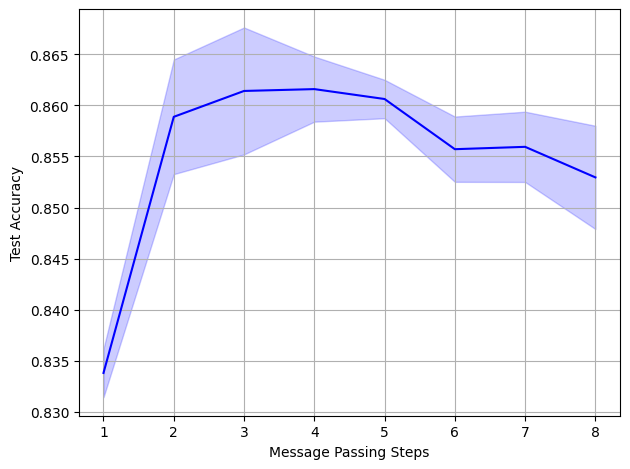

In [44]:
mean, std = np.mean(es_test_metrics[:7], axis=0), np.std(es_test_metrics[:7], axis=0)
plt.plot(range(1, DEPTH+1), mean, color='blue')
plt.fill_between(range(1, DEPTH+1), mean-std, mean+std, alpha=0.2, color='blue')
plt.xlabel('Message Passing Steps')
plt.ylabel(f'Test {METRIC}')
plt.grid()
plt.tight_layout()
plt.show()